# Notebook 3: Pipeline, Model Benchmark & Model Selection

### Data Load/Import

In [1]:
# Import relevant libraries
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import my_helper_functions as mhf
import pandas_profiling as prof
import missingno as msno
import pivottablejs as pvt
import datetime as dt
import os
import xgboost as xgb
%matplotlib inline

In [2]:
# Load in the data
_names =['dnum', 'dnum_country', 'dnum_vendor', 'dnum_factory', 'dnum_brand', 'dnum_molecule_test'
         , 'dnum_lpifsi', 'ddate', 'dobject','dtrend']
data_dict = mhf.load_clean_data(names_ =_names) 
print("Dataframes available: {} \n The data shapes: \n---{}".format(data_dict.keys()
                                                                    ,[d.shape for d in data_dict.values()]))
#Assign to named dataframes
dnum,dnum_country, dnum_vendor,dnum_factory,dnum_brand,dnum_molecule_test,dnum_lpifsi,ddate, dobject, dtrend = [data_dict[n] for n in _names]
dobject = dobject.apply(lambda x: pd.Categorical(x))
ddate['delivery_delay_time'] = ddate['delivery_delay_time'].apply(lambda x: pd.to_timedelta(x))

trying normal method for: ...  0
Sucess for: ...  0
trying normal method for: ...  1
Sucess for: ...  1
trying normal method for: ...  2
Sucess for: ...  2
trying normal method for: ...  3
Sucess for: ...  3
trying normal method for: ...  4
Sucess for: ...  4
trying normal method for: ...  5
Sucess for: ...  5
trying normal method for: ...  6
Sucess for: ...  6
trying normal method for: ...  7
Sucess for: ...  7
trying normal method for: ...  8
Sucess for: ...  8
trying normal method for: ...  9
Sucess for: ...  9
Dataframes available: dict_keys(['dnum', 'dnum_country', 'dnum_vendor', 'dnum_factory', 'dnum_brand', 'dnum_molecule_test', 'dnum_lpifsi', 'ddate', 'dobject', 'dtrend']) 
 The data shapes: 
---[(10324, 9), (10324, 12), (10324, 12), (10324, 12), (10324, 12), (10324, 12), (10324, 25), (10324, 10), (10324, 88), (10324, 6)]


### Use Feature Selection Results 
#### Supported by Dimensionality Reduction, Feature Importance analysis from previous notebook

In [3]:
so =[ #'pq_date_new_yr', 'pq_date_new_mn', 'pq_date_new_dy',
 'po_date_new_yr', 'po_date_new_mn', 'po_date_new_dy',
  'del_date_scheduled_mn', 'del_date_scheduled_dy'
 #, 'del_date_client_yr', 'del_date_client_mn','del_date_client_dy'
 #, 'del_date_recorded_yr', 'del_date_recorded_mn','del_date_recorded_dy'
 #, 'pq_date_new_wd', 'pq_date_new_wk','pq_date_new_qt'
 , 'po_date_new_wd', 'po_date_new_wk', 'po_date_new_qt'
 ,'del_date_scheduled_wd', 'del_date_scheduled_wk','del_date_scheduled_qt'
 #, 'del_date_client_wd', 'del_date_client_wk','del_date_client_qt'
 #, 'del_date_recorded_wd', 'del_date_recorded_wk','del_date_recorded_qt'
 #, 'delayed'
 #, 'proj_code', 'pq_no', 'po_no','ship_no'
 #, 'country'
    , 'mngr', 'fulfill_via', 'vendor_terms'
 ,'ship_mode'
 #, 'pq_date'
 #, 'po_date'
    , 'prod_grp', 'sub_class'
    , 'vendor'
 #,'itm_desc'
 , 'molecule_test', 'brand', 'dosage'
 , 'dosage_form','factory'
    , 'first_line'
 #, 'weight', 'freight_cost'
 ,'del_date_scheduled_yr', 'ship_config', 'weight_captured_seperately'
 ,'freight_invoiced_seperately', 'freight_in_cmdty_cost'
 #,'factory_address'
 , 'origin_country'
    , 'origin_continent'
 #, 'name'
 , 'dest_country'
# , 'orig_origin_country'
]

snlf = [#'dest_mean', 'dest_sum', 'dest_count'
        #, 'orig_mean', 'orig_sum','orig_count',
    'dest_fsi','dest_intl_ship', 'dest_timeliness'
, 'dest_track_trace', 'dest_customs', 'dest_lpi', 'dest_infra',
        'dest_logistic_qlty',
    'orig_fsi','dest_count','orig_intl_ship', 'orig_timeliness'
, 'orig_track_trace', 'orig_customs', 'orig_lpi', 'orig_infra',
        'orig_logistic_qlty']

#dnum
sn =['ln_itm_qty', 'ln_itm_val', 'pk_price','line_itm_ins', 'ln_itm_weight']
# dnum_country
snc =  ['country_qtycount', #'country_qtymean',
        'country_valmean',# 'country_insmean',
       'country_weightmean'#,  'country_costmean'
       ]
# dnum_vendor
snv=[#'vendor', 'vendor_qtycount',
     'vendor_qtysum',
       'vendor_qtymean'
    , 'vendor_valsum', 'vendor_valmean', 'vendor_inssum',
       'vendor_insmean', 'vendor_weightsum',  'vendor_costsum'
]
# dnum_factory
snf=[#'factory',
     'factory_qtycount', 
     'factory_qtymean'#, 'factory_valmean','factory_costmean'
    ]
#dnum_brand
snb = [#'brand',  'brand_qtymean',      
       'brand_valmean'
#       ,'brand_insmean', 'brand_weightsum', 'brand_weightmean', 'brand_costmean'
]
#dnum_molecule_test
snm=[#'molecule_test', 
     'molecule_test_qtycount'
     #,'molecule_test_qtymean', 'molecule_test_valmean'
     ,'molecule_test_insmean']

---
## 1. Model Pipeline
---

### Make Pipeline

In [4]:
# Use Feature Selection columns
dn,dnc, dnv = dnum[sn],dnum_country[snc], dnum_vendor[snv] 
dnf, dnb, dnm = dnum_factory[snf],dnum_brand[snb],dnum_molecule_test[snm]
dnlf = dnum_lpifsi[snlf]
do =  dobject[so]
# #ddate #dt #do

# Import pipeline and preprocessing modules 
from sklearn.preprocessing import FunctionTransformer,PolynomialFeatures, normalize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer ,StandardScaler
from sklearn.pipeline import TransformerMixin, _BaseComposition 
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

log1p = FunctionTransformer(np.log1p)
make_num_pipe = make_pipeline(log1p, StandardScaler()) 
make_num_pipe_2 = make_pipeline(StandardScaler()) 
make_cat_pipe = make_pipeline(mhf.Dummifier())
make_lab_pipe = make_pipeline(mhf.Labeler())

# Drop redundant columns
entities =['country', 'factory', 'vendor', 'brand', 'molecule_test']
for d in [dnc, dnf, dnv, dnb, dnm]:
    for c in entities:
        try:
            d.drop(c, axis=1, inplace=True)
        except:
            pass
        
# Selective data        
dn,dnc, dnf, dnv, dnb, dnm = [pd.DataFrame(make_num_pipe.fit_transform(d), index=d.index
                            , columns=d.columns) for d in [dn,dnc, dnf, dnv, dnb, dnm]]
dnlf = pd.DataFrame(make_num_pipe_2.fit_transform(dnlf), index=dnlf.index,columns=dnlf.columns) 
dtr = pd.DataFrame(make_num_pipe_2.fit_transform(dtrend), index=dtrend.index,columns=dtrend.columns)
do = make_cat_pipe.fit_transform(do)

# Delayed
delayed=pd.DataFrame(make_lab_pipe.fit_transform(dobject.delayed.map({True:1, False:0})), columns=['delayed'])
try:
    do.drop('delayed', axis=1, inplace=True)
    do_alt.drop('delayed', axis=1, inplace=True)
except:
    pass

data = pd.concat([do,dnlf,dn,dnc, dnv, dnf, dnb, dnm,dtr], axis=1)

print("\n---\n",data.shape,ddate.columns)
#print("\n---\n",data_alt.shape,ddate.columns)

# Remember the ddate dataframe will be needed later for regression


---
 (10324, 700) Index(['del_date_scheduled', 'del_date_client', 'del_date_recorded', 'pq_date',
       'po_date', 'po_date_new', 'pq_date_new', 'anticipated_lead_time',
       'actual_lead_time', 'delivery_delay_time'],
      dtype='object')


In [5]:
dataCpy = data.copy(deep=True)
for column in data.columns:
    #print(column)
    count_nan = data[column].isnull().sum()
    if count_nan > 0:
        dataCpy = dataCpy.drop(columns= column)

---
## 2. Model Benchmarks
---

In [6]:
# Import all the modules for Modeling and Prediction
# Import sklearn and models
from sklearn.ensemble import  BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB    
from sklearn.neural_network import MLPClassifier, MLPRegressor 
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
import yellowbrick as yb
from imblearn.over_sampling import SMOTE

### Classification Benchmark
#### *Random Forest Classifier with Default parameter*

XTrain, yTrain shapes BEFORE Oversampling: (6710, 692) and (6710, 1)
XTrain, yTrain shapes AFTER Oversampling: (6710, 692) and (6710, 1)
Shape of XTrain: (6710, 692) yTrain: (3614, 692) XTest: (6710, 1) yTest: (3614, 1)

----

Total Importance of 30 features: importance    0.549542
dtype: float64


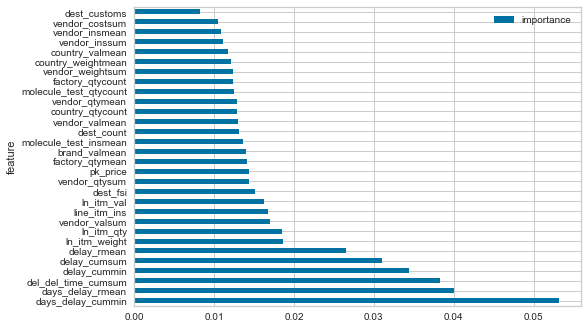

In [7]:
# Partition the data into predictors and label
X_clf= dataCpy
y_clf = delayed
# Train test split custom function with OverSampling to balance datasets if required
X_tr_clf, X_ts_clf, y_tr_clf, y_ts_clf = mhf.train_test_oversample(X_clf
                                                                                   , y_clf, test_size=0.35, use_smote=False)
print("\n----\n")
# Fit the regression to the data and train
clf = RandomForestClassifier(random_state=121)
clf.fit(X_tr_clf, y_tr_clf)
d_feat_imp_clf = mhf.plot_feature_importances(clf, X_tr_clf, 30)

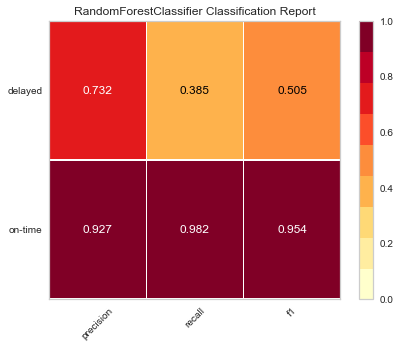

ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000013FCF6A9A00>,
                     classes=['on-time', 'delayed'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x0000013FCF6D5880>,
                     estimator=Pipeline(steps=[('estimator',
                                                RandomForestClassifier(random_state=121))]))

In [8]:
# Predict and plot F1-Scores, Precision and Recall
plt.subplots(figsize=(6,5))
y_pred_clf = clf.predict(X_ts_clf)
mhf.visual_model_selection(X_tr_clf, X_ts_clf, y_tr_clf, y_ts_clf, clf)

In [9]:
# Make dataframe of delayed vs. predicted
df_pred=pd.DataFrame(y_ts_clf, columns=['delayed']); df_pred['pred']= y_pred_clf
print(df_pred.describe().T)
# Make DataFrame of True Positives for regression prediction (length/extent of delay) 
df_true_pos = df_pred[(df_pred.delayed==1) & (df_pred.delayed==df_pred.pred)]
print(df_true_pos.sum())
# Save to disk
path = os.curdir+"\Data\Results\\"
df_pred.to_csv(path+'classifier_benchmark_predicted.csv')
df_true_pos.to_csv(path+'classifier_benchmark_true_positives.csv') # Save to data folders
# Plot to visualize the prediction
#plt.subplots(figsize=(15,2))
#plt.scatter(df_pred.index, df_pred.iloc[:,0], color='b')
#plt.scatter(df_pred.index, df_pred.iloc[:,1], color='r')
#plt.title("Plotting Predictions (Red) over Actuals (Blue)")

          count      mean       std  min  25%  50%  75%  max
delayed  3614.0  0.112064  0.315489  0.0  0.0  0.0  0.0  1.0
pred     3614.0  0.058937  0.235540  0.0  0.0  0.0  0.0  1.0
delayed    156
pred       156
dtype: int64


#### Inspect the False Positive and False Negatives

In [10]:
# Get a sense of what the model is missing
# Go back to feature engineering

### Regression Model Benchmark
#### *Random Forest Regressor with Default parameter*

In [11]:
# Here, for regression, we training only on the positive samples? 
# Conditional probability question changes things. BAYES!
X_tr_reg, X_ts_reg, y_tr_reg, y_ts_reg = mhf.train_test_conditional(X_clf, y_clf, df_true_pos, ddate, delayed)

Now getting train test splits for regression...
Shapes:
 (1030, 692)
,(156, 692)
,(1030,)
,(156,)


Total Importance of 30 features: importance    0.743261
dtype: float64


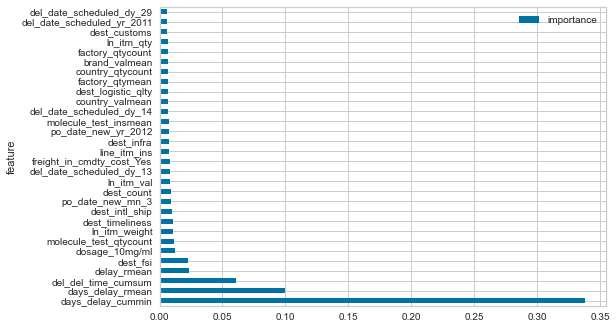

In [12]:
# Instantiate the regression, fit and plot
reg = RandomForestRegressor(random_state=121)
reg.fit(X_tr_reg, y_tr_reg)
d_feat_imp_reg = mhf.plot_feature_importances(reg, X_tr_reg, 30)

R-Squared:  0.9038226401821028 RMSE : 9.918639859711949 Target Variable Mean:  24.41025641025641


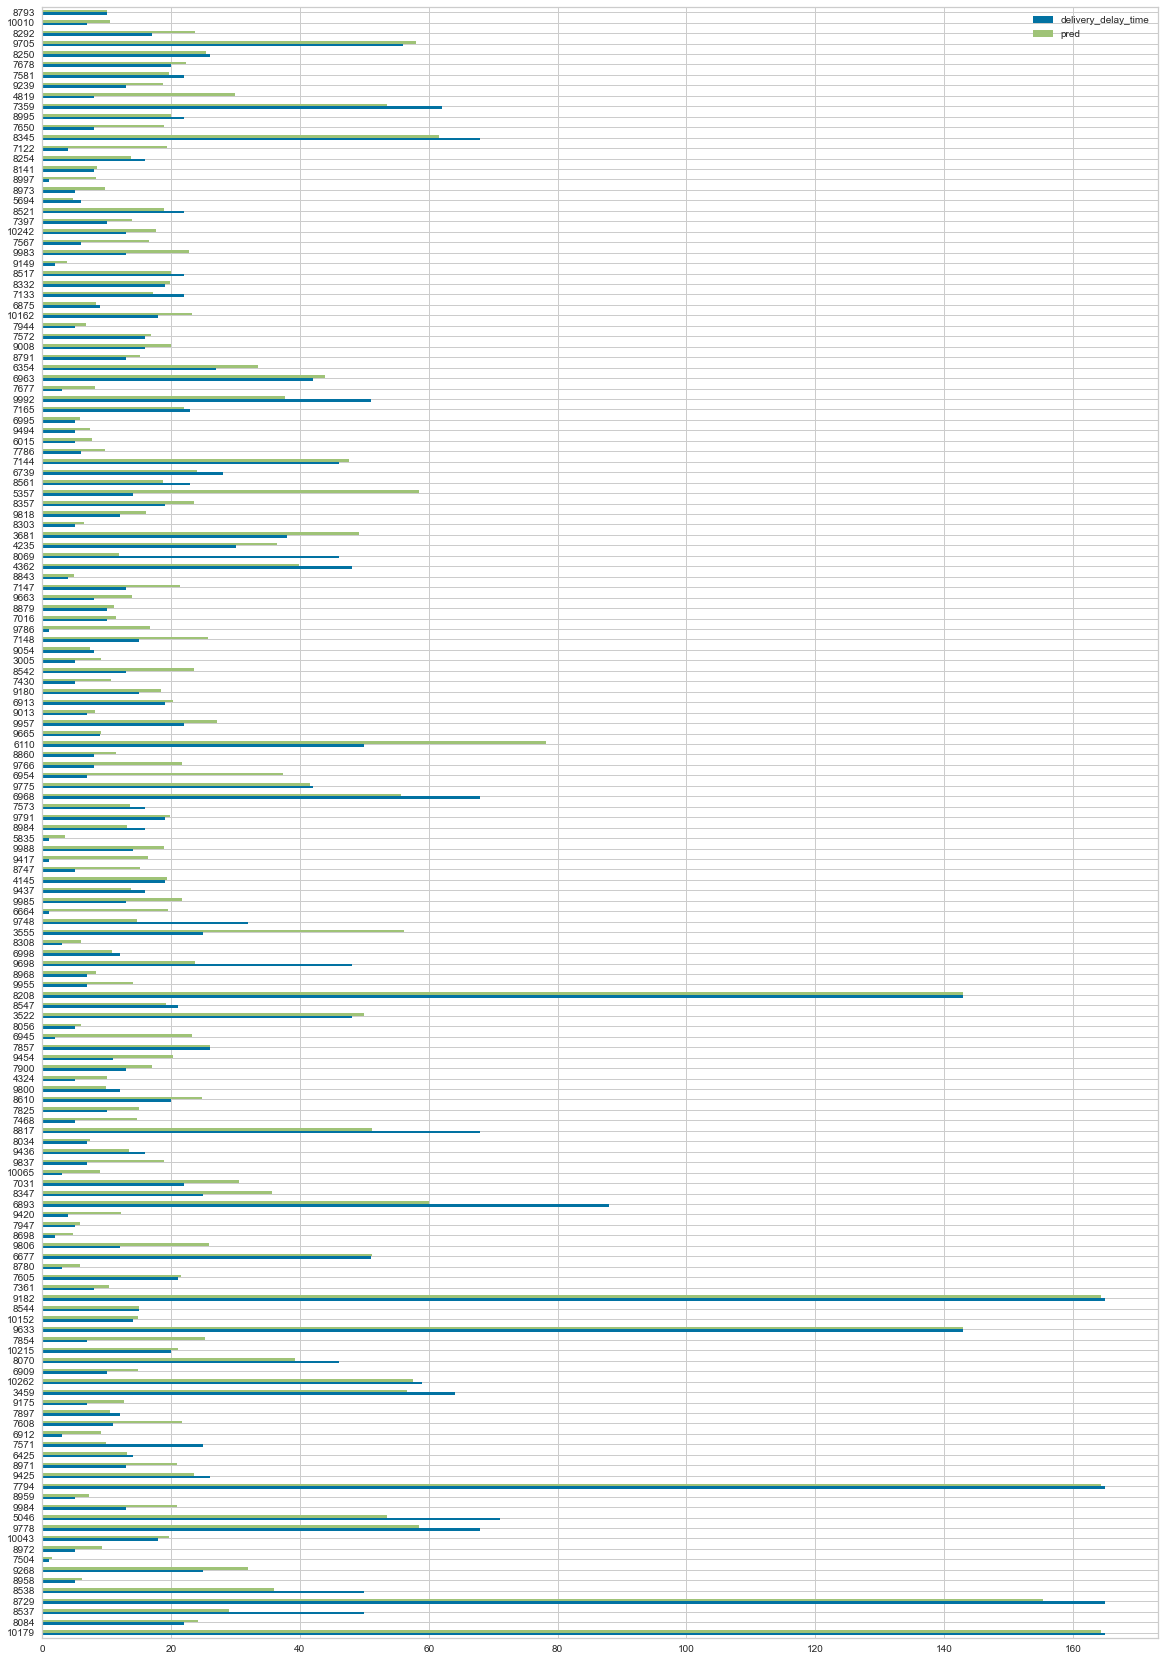

In [13]:
# Predicts the test values
y_pred_reg = reg.predict(X_ts_reg)
# Accuracy and error calcs
r2, rmse = metrics.r2_score(y_ts_reg, y_pred_reg), np.sqrt(metrics.mean_squared_error(y_ts_reg, y_pred_reg))
print("R-Squared: ", r2, "RMSE :", rmse, "Target Variable Mean: ", y_ts_reg.mean())
# Print out the test and pred side by side
df_pred_reg =pd.DataFrame(y_ts_reg)
df_pred_reg['pred']= y_pred_reg
df_pred_reg.plot(kind="barh", figsize=(20,30))

### Benchmark Model Findings

- **RandomForest Classifier**
    - F1-score of ~44%, Recall of 33%, and Precision of 71%.
    - The top 30 features explain almost 80% of the model.
    - More feature ideas - polynomials, combinations of features, add the time series aspect instead of features from time components?
    
    
- **RandomForest Regressor**
    - Does decently well, at R2 of 80%
    - RMSE of 16 days compared to a mean of 27 days among the delayed items 

---
## 3.  Model Selection
---
Try out several models and pick the most promising ones to fine-tune into the final model

### Select Classifier 

XTrain, yTrain shapes BEFORE Oversampling: (6710, 692) and (6710, 1)
XTrain, yTrain shapes AFTER Oversampling: (6710, 692) and (6710, 1)
Shape of XTrain: (6710, 692) yTrain: (3614, 692) XTest: (6710, 1) yTest: (3614, 1)


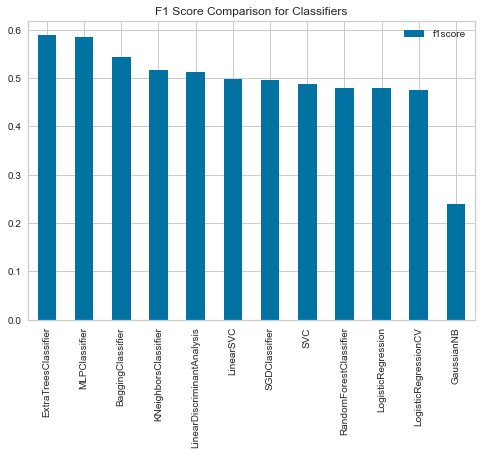

In [14]:
# Train test split custom function with OverSampling to balance datasets if required
X_tr_clf_sel, X_ts_clf_sel, y_tr_clf_sel, y_ts_clf_sel = mhf.train_test_oversample(X_clf
                                                                                   , y_clf, test_size=0.35, use_smote=False)
# List of classifiers
clfs = [LinearSVC, SVC, KNeighborsClassifier, LogisticRegressionCV, LogisticRegression, SGDClassifier
,BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, MLPClassifier
       ,GaussianNB, LinearDiscriminantAnalysis]
# List of classiffier names
cn = ['LinearSVC' , 'SVC', 'KNeighborsClassifier', 'LogisticRegressionCV', 'LogisticRegression', 'SGDClassifier'
,'BaggingClassifier', 'ExtraTreesClassifier', 'RandomForestClassifier', 'MLPClassifier'
      , 'GaussianNB', 'LinearDiscriminantAnalysis']   
# Plot the f1 scores
acc = []
for clf in clfs:
    try:
        acc.append(mhf.model_selection(X_tr_clf_sel, X_ts_clf_sel, y_tr_clf_sel, y_ts_clf_sel
                                       , clf(), 'clf'))
    except:
        acc.append(0)
d_acc = pd.DataFrame(acc, cn)
d_acc.columns = ["f1score"]
d_acc.sort_values(by ='f1score',ascending=False).plot(kind="bar", title="F1 Score Comparison for Classifiers")

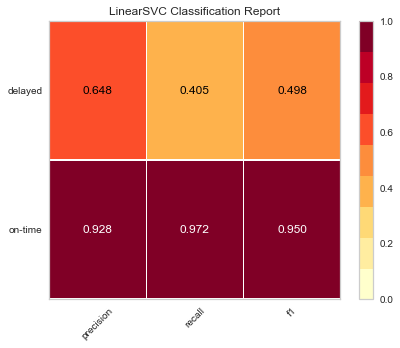

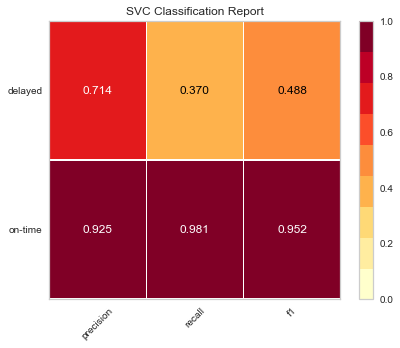

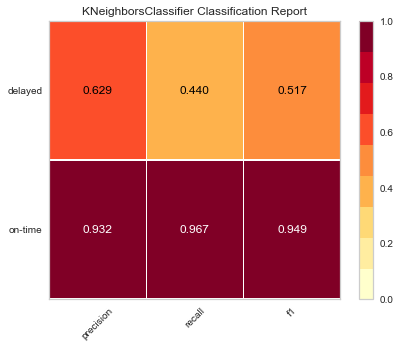

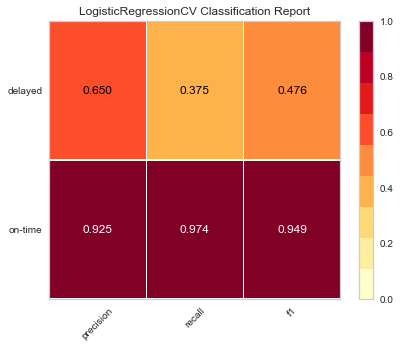

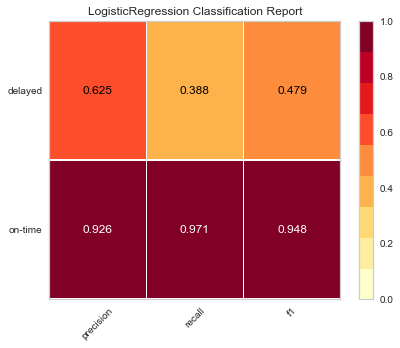

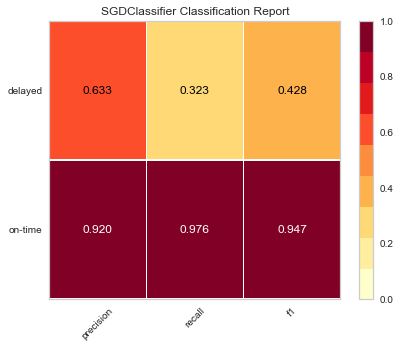

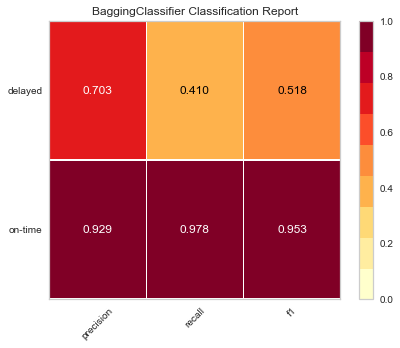

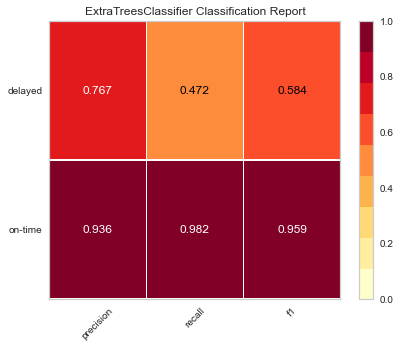

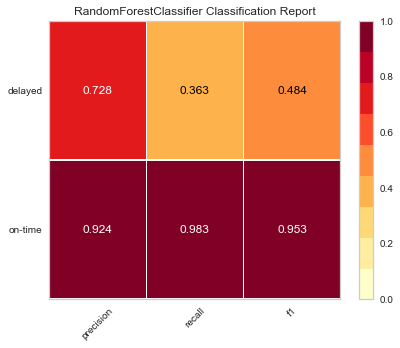

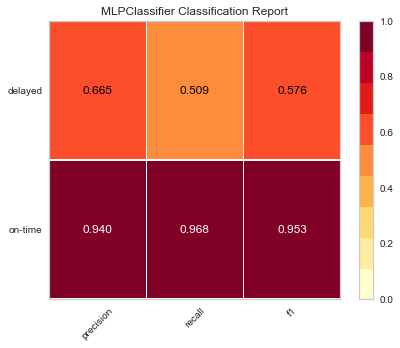

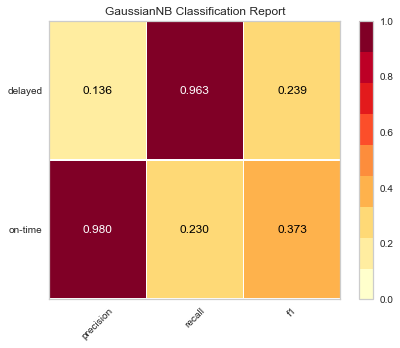

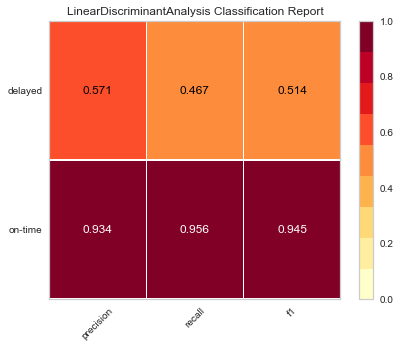

In [15]:
# Plot the classification reports
for clf in clfs:
    plt.subplots(figsize=(6,5))
    i=clfs.index(clf)
    mhf.visual_model_selection(X_tr_clf_sel, X_ts_clf_sel, y_tr_clf_sel, y_ts_clf_sel, clfs[i]())

#### Classification Candidate Models:
1. ExtraTreesClassifier
2. MLPClassifer
3. BaggingClassifer
4. RandomForestClassifier


### Select Regressor

Shape of true positive df:  (193, 2) Number of 1's in true positive df: delayed    193
pred       193
dtype: int64
Now getting train test splits for regression...
Shapes:
 (993, 692)
,(193, 692)
,(993,)
,(193,)


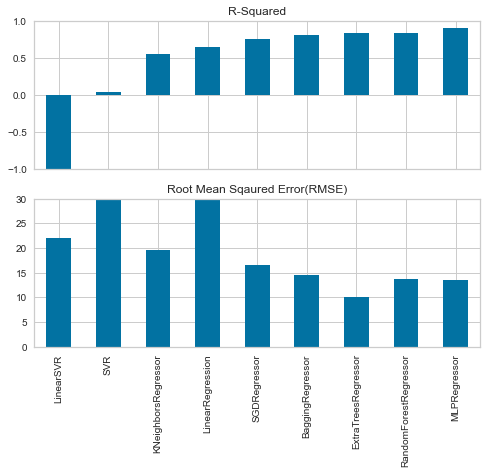

In [16]:
# First generate true positives to predict on 
# Use favorite classifier selected thus far
estimator = ExtraTreesClassifier(random_state=121)
df_true_pos_sel = mhf.fit_and_generate_true_positives(estimator, X_tr_clf_sel, X_ts_clf_sel, y_tr_clf_sel, y_ts_clf_sel)[0]
# Get training and test sets...
X_tr_reg_sel, X_ts_reg_sel, y_tr_reg_sel, y_ts_reg_sel = mhf.train_test_conditional(X_clf,
                                                                                    y_clf, df_true_pos_sel, ddate, delayed)

# List of regressors
regs = [LinearSVR, SVR, KNeighborsRegressor, LinearRegression , SGDRegressor,
        BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, MLPRegressor]
# List of regressor names
rn = ['LinearSVR', 'SVR', 'KNeighborsRegressor', 'LinearRegression', 'SGDRegressor',
    'BaggingRegressor', 'ExtraTreesRegressor', 'RandomForestRegressor', 'MLPRegressor']   
# Plot the f1 scores
rsq = []
for reg in regs:
    try:
        rsq.append(mhf.model_selection(X_tr_reg_sel, X_ts_reg_sel, y_tr_reg_sel, y_ts_reg_sel, reg(), 'reg'))
    except:
        rsq.append((0,0))
d_rsq = pd.DataFrame(rsq, rn, columns=['r2', 'rmse'])
f , (ax0,ax1) = plt.subplots(2,1, figsize=(8,6), sharex=True,)
d_rsq['r2'].sort_values().plot(kind="bar", ax=ax0, ylim=(-1,1), title="R-Squared")
d_rsq['rmse'].plot(kind="bar", ax=ax1, title="Root Mean Sqaured Error(RMSE)", ylim=(0,30))

In [17]:
d_rsq.sort_values('r2', ascending=False)

,r2,rmse
ExtraTreesRegressor,9.041857e-01,1.017367e+01
MLPRegressor,8.332871e-01,1.341983e+01
RandomForestRegressor,8.279508e-01,1.363292e+01
BaggingRegressor,8.060528e-01,1.447452e+01
SGDRegressor,7.475009e-01,1.651552e+01
KNeighborsRegressor,6.458938e-01,1.955821e+01
LinearSVR,5.504030e-01,2.203810e+01
SVR,3.723488e-02,3.224947e+01
LinearRegression,-9.655707e+19,3.229643e+11


#### Regression Candidate Models
1. ExtraTreesRegressor
2. BaggingRegressor 
3. MLPRegressor
3. RandomForestRegressor

---
## 4. Model Refinement
---

### Run Final Model and Evaluation Metrics
(i) Classification: ***ExtraTreesClassifier***
(ii) Regression: ***ExtraTreesRegressor*** 

XTrain, yTrain shapes BEFORE Oversampling: (6710, 692) and (6710, 1)
XTrain, yTrain shapes AFTER Oversampling: (11858, 692) and (11858, 1)
Shape of XTrain: (11858, 692) yTrain: (3614, 692) XTest: (11858, 1) yTest: (3614, 1)


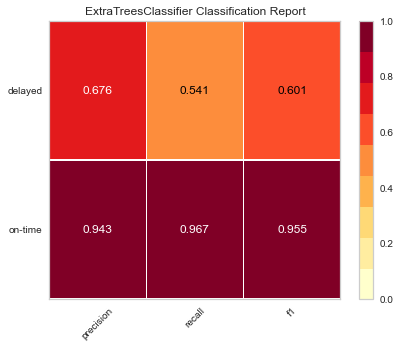

Shape of true positive df:  (219, 2) Number of 1's in true positive df: delayed    219
pred       219
dtype: int64
Now getting train test splits for regression...
Shapes:
 (967, 692)
,(219, 692)
,(967,)
,(219,)
---
R-Squared:  0.8586637944150615  ---
RMSE: 11.776861389799684


In [18]:
clf_final = ExtraTreesClassifier(n_estimators=900,max_features= 50
                                  ,criterion= 'entropy',max_depth= 50, random_state=121)
reg_final = ExtraTreesRegressor(n_estimators=900 ,max_features= 50,max_depth= 50, random_state=121)
X_tr_clf_fin, X_ts_clf_fin, y_tr_clf_fin, y_ts_clf_fin = mhf.train_test_oversample(dataCpy
                                                        , delayed, test_size=0.35, use_smote=True)
plt.subplots(figsize=(6,5))
score_fin=mhf.visual_model_selection(X_tr_clf_fin, X_ts_clf_fin, y_tr_clf_fin, y_ts_clf_fin, clf_final)

df_true_pos_fin = mhf.fit_and_generate_true_positives(clf_final, X_tr_clf_fin, X_ts_clf_fin,
                                                      y_tr_clf_fin, y_ts_clf_fin)[0]
X_tr_reg_fin, X_ts_reg_fin, y_tr_reg_fin, y_ts_reg_fin = mhf.train_test_conditional(dataCpy,
                                                                    delayed, df_true_pos_fin, ddate, delayed)
rsq = []
rsq.append(mhf.model_selection(X_tr_reg_fin, X_ts_reg_fin, y_tr_reg_fin, y_ts_reg_fin, reg_final, 'reg'))
print("---\nR-Squared: ", rsq[0][0]," ---\nRMSE:", rsq[0][1])

#### Models Playground/SandBox:
#### Try different combinations of models, alternative data features etc. 

In [19]:
clf_play = MLPClassifier(hidden_layer_sizes=(100,30, 100), activation='relu', solver='adam', alpha=0.0001
                         , batch_size='auto', learning_rate='constant', learning_rate_init=0.001
                         , power_t=0.5, max_iter=700, shuffle=True, random_state=121, tol=0.0001
                         , verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True
                         , early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
reg_play = ExtraTreesRegressor(n_estimators=900 ,max_features= 50,max_depth= 50, random_state=121)

df_pred_play, df_true_pos_play,  d_feat_imp_clf_play, clfreport_play, cmatrix_play, r2_play, rmse_play = mhf.run_combined_classify_regress_model_prefit(
                                            dataCpy, ddate, delayed,clf_play, reg_play,test_size=0.35, use_smote=True, show_plot=False)
print("---\nClassification Report:\n {} ---\n Confusion Matrix:\n {} ---\n \
      RSquared: {}  and RMSE: {}".format(clfreport_play, cmatrix_play, r2_play, rmse_play))

XTrain, yTrain shapes BEFORE Oversampling: (6710, 692) and (6710, 1)
XTrain, yTrain shapes AFTER Oversampling: (11858, 692) and (11858, 1)
Shape of XTrain: (11858, 692) yTrain: (3614, 692) XTest: (11858, 1) yTest: (3614, 1)

----

Classifier has no feature importance attributes
Now getting train test splits for regression...
Shapes:
 (984, 692)
,(202, 692)
,(984,)
,(202,)
---
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      3209
           1       0.66      0.50      0.57       405

    accuracy                           0.92      3614
   macro avg       0.80      0.73      0.76      3614
weighted avg       0.91      0.92      0.91      3614
 ---
 Confusion Matrix:
 [[3105  104]
 [ 203  202]] ---
       RSquared: 0.8375658166260502  and RMSE: 13.037855691944262


In [20]:
# Rand
# {'f1': {'delayed': 0.45378151260504201, 'on-time': 0.95100256294286156},
#  'precision': {'delayed': 0.71052631578947367, 'on-time': 0.92114485981308414},
#  'recall': {'delayed': 0.33333333333333331, 'on-time': 0.98286070426924277}}
# R-Squared:  0.807007307896 RMSE : 15.913437136 Target Variable Mean:  26.844444444444445
# 135 delays detected

#Xtra
# {'f1': {'delayed': 0.60205580029368577, 'on-time': 0.95860699557049023},
#  'precision': {'delayed': 0.74275362318840576, 'on-time': 0.94008388256440978},
#  'recall': {'delayed': 0.50617283950617287, 'on-time': 0.97787472732938607}}
    
# R-Squared:  0.862636593432  ---
# RMSE: 11.9738387556
# 205 delays detected same(test-set size)

# Checkpoint 3
### Next Notebook: Final Model and Results